## Imports

In [502]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (14,8)

## UFO class

Keep track of individual UFOs through the pipeline

In [472]:
class UFO:
    def __init__(self, index, start_time):
        self.index = index
        self.start_time = start_time
        self.part_done = {'engine': False, 'dome': False}
        self.queue_time = {'engine': 0., 'dome': 0.}
        self.installation_time = {'engine': 0., 'dome': 0.}
        
    def install_part(self, part, queue_time, installation_time):
        self.part_done[part] = True
        self.queue_time[part] = queue_time
        self.installation_time[part] = installation_time
        
    def total_time_part(self, part):
        return self.queue_time[part] + self.installation_time[part]
    
    def total_time(self):
        return self.total_time_part('engine') + self.total_time_part('dome')
    
    def total_queue_time(self):
        return self.queue_time['engine'] + self.queue_time['dome']
    
    def total_assembly_time(self):
        return self.installation_time['engine'] + self.installation_time['dome']
    
    def finished(self):
        return self.part_done['engine'] and self.part_done['dome']

## Our Factory simulation object

This is where we give all the parameters of our simulation environment, keep the actual environment, kickstart processes and do analysis

In [543]:
class Factory:
    def __init__(self, arrival_rate, engine_initial_amount, engine_restock_level, engine_restock_amount, engine_restock_time,
                 eng_assembly_capacity, eng_assembly_service_rate, eng_assembly_break_probability,
                 dome_initial_amount, dome_restock_level, dome_restock_amount, dome_restock_time,
                 dome_assembly_capacity, dome_assembly_service_rate, dome_assembly_break_probability,
                 mechanic_capacity, mechanic_service_rate, debug=False):
        
        self.arrival_rate = arrival_rate
        self.factory = simpy.Environment()
        
        self.mechanic = Mechanic(self.factory, mechanic_capacity, mechanic_service_rate, debug)
        self.engine_storage = Storage(self.factory, 'engine', engine_initial_amount, engine_restock_level, 
                                      engine_restock_amount, engine_restock_time, debug)
        self.engine_assembly = Assembly(self.factory, 'engine', eng_assembly_capacity, self.engine_storage, self.mechanic, 
                                        eng_assembly_service_rate, eng_assembly_break_probability, debug)
        self.dome_storage = Storage(self.factory, 'dome', dome_initial_amount, dome_restock_level, 
                                    dome_restock_amount, dome_restock_time, debug)
        self.dome_assembly = Assembly(self.factory, 'dome', dome_assembly_capacity, self.dome_storage, self.mechanic,
                                      dome_assembly_service_rate, dome_assembly_break_probability, debug)
        
        self.ufos = []
        self.debug = debug 
        
        self.factory.process(self.order_arrivals(arrival_rate))

    def order_arrivals(self, arrival_rate):
        ufo_counter = 0
        while True:
            time_to_wait = stats.expon.rvs(scale=arrival_rate)
            yield self.factory.timeout(time_to_wait)
            if self.debug:
                print('Order UFO', ufo_counter, 'came in at', self.factory.now)
            ufo = UFO(ufo_counter, self.factory.now)
            self.ufos.append(ufo)
            self.factory.process(self.process_ufo(ufo))
            ufo_counter += 1
            
    def process_ufo(self, ufo):
        if self.debug:
            print('Process UFO', ufo.index, 'start engine at', self.factory.now)
        yield self.factory.process(self.engine_assembly.assemble_part(ufo))
        if self.debug:
            print('Process UFO', ufo.index, 'start dome at', self.factory.now)
        yield self.factory.process(self.dome_assembly.assemble_part(ufo))
            
    def run(self, time=None):
        self.factory.run(time)
        self.finished_ufos = [u for u in self.ufos if u.finished()]
        
    def waiting_times(self):
        return [u.total_queue_time() for u in self.finished_ufos]
    
    def percentage_within_time(self, time):
        return np.mean([w < time for w in self.waiting_times()])
        
    def analysis(self):
        start_times = [u.start_time for u in self.finished_ufos]
        waiting_times = self.waiting_times()
        plt.plot(start_times, waiting_times)
        plt.title('Time waited')
        plt.xlabel('Time')
        plt.ylabel('Time waited')
        plt.show()
        
        service_times = [u.total_assembly_time() for u in self.finished_ufos]
        waiting_time_fraction = np.sum(waiting_times) / (np.sum(waiting_times) + np.sum(service_times))
        ax = sns.barplot(['Waiting', 'Assembly'], [waiting_time_fraction, 1-waiting_time_fraction])
        ax.set_title('Waiting time fraction')
        plt.show()
        
        ax = sns.distplot(waiting_times, kde=False)
        ax.set_title('Waiting time distribution')
        plt.show()

        ax = sns.distplot(service_times, kde=False)
        ax.set_title('Service time distribution')
        plt.show()
        
        x = [self.mechanic.request_times[0]] + [val for val in self.mechanic.request_times[1:-1] for _ in (0, 1)] + \
            [self.mechanic.request_times[-1]]
        y = [0, 0] + [val for val in self.mechanic.number_mechanics_busy[1:-1] for _ in (0, 1)]
        plt.plot(x, y)
        plt.title('Mechanics busy at request times')
        plt.xlabel('Time')
        plt.ylabel('Number mechanics busy')
        plt.show()

        stock_levels = self.engine_storage.stock_levels_at_restock
        ax = sns.barplot(list(range(len(stock_levels))),stock_levels)
        ax.set_title('Stock levels engine')
        plt.show()
        
        stock_levels = self.dome_storage.stock_levels_at_restock
        ax = sns.barplot(list(range(len(stock_levels))),stock_levels)
        ax.set_title('Stock levels dome')
        plt.show()

## Mechanic resource

In [528]:
class Mechanic:
    def __init__(self, env, capacity, service_rate, debug):
        self.env = env
        self.capacity = capacity
        self.service_rate = service_rate
        self.debug = debug
        self.resource = simpy.Resource(env, self.capacity)
        self.sampled_service_times = []
        self.number_mechanics_busy = []
        self.request_times = []
        
    def sample_service(self):
        service_time = stats.expon.rvs(scale=self.service_rate) 
        self.sampled_service_times.append(service_time)
        return service_time
    
    def request(self):
        self.request_times.append(self.env.now)
        self.number_mechanics_busy.append(len(self.resource.users))
        return self.resource.request()

## Storage resource

In [484]:
class Storage(simpy.Container):
    def __init__(self, env, part, initial_amount, restock_level, restock_amount, restock_time, debug):
        self.env = env
        self.part = part
        self.restock_level = restock_level
        self.restock_amount = restock_amount
        self.restock_time = restock_time
        self.debug = debug
        self.restock_order_initiated = False
        self.stock_levels_at_restock = []
        super().__init__(env=env, init=initial_amount)
        
    def restock_storage(self):
        if not self.restock_order_initiated and self.level < self.restock_level:
            self.restock_order_initiated = True
            if self.debug:
                print('Part', self.part, 'restocking initiated at', self.env.now)
            yield self.env.timeout(self.restock_time)
            yield self.put(self.restock_amount)
            if self.debug:
                print('Part', self.part, 'restocked at', self.env.now, ', current level', self.level)
            self.stock_levels_at_restock.append(self.level - self.restock_amount)
            self.restock_order_initiated = False
    
    def get_part(self):
        self.env.process(self.restock_storage())
        return self.get(1)

## Assembly resource

In [328]:
class Assembly:
    def __init__(self, env, part, capacity, storage, mechanic, service_rate, break_probability, debug):
        self.env = env
        self.part = part
        self.storage = storage
        self.mechanic = mechanic
        self.capacity = capacity
        self.service_rate = service_rate
        self.break_probability = break_probability
        self.debug = debug
        self.resource = simpy.Resource(env, self.capacity)
        
    def assemble_part(self, ufo):
        queueing_start = self.env.now
        with self.resource.request() as assembly:
            with self.storage.get_part() as part:
                yield assembly & part
                assembly_start = self.env.now
                if self.debug:
                    print('Gathered', self.part, 'for UFO', ufo.index, ', assembly starts at', assembly_start)
                done = False
                while not done:
                    machine_break = np.random.rand() < self.break_probability
                    if machine_break:
                        machine_break_time = self.env.now
                        if self.debug:
                            print('Machine broken during assembly', self.part, 'for UFO', ufo.index, 'at', self.env.now)
                        with self.mechanic.request() as mechanic_request:
                            yield mechanic_request
                            mechanic_fixing_time = self.mechanic.sample_service()
                            if self.debug:
                                print('UFO', ufo.index, 'waited', self.env.now - machine_break_time, ', fixing starts now', self.env.now)
                            yield self.env.timeout(mechanic_fixing_time)
                            if self.debug:
                                print('Mechanic service time for UFO', ufo.index, 'was', mechanic_fixing_time)
                    else:
                        assembly_time = stats.expon.rvs(scale=self.service_rate)
                        yield self.env.timeout(assembly_time)
                        assembly_finished = self.env.now
                        ufo.install_part(self.part, assembly_start - queueing_start, assembly_finished - assembly_start)
                        done = True

### Putting it all together in a first run with analysis

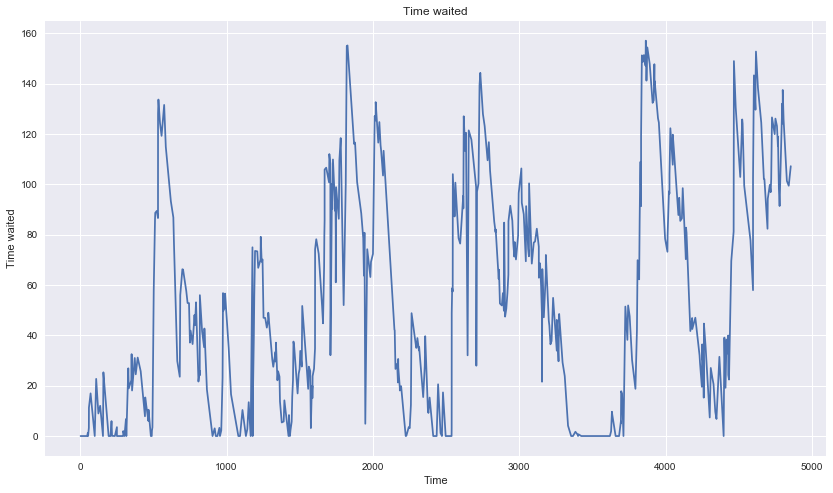

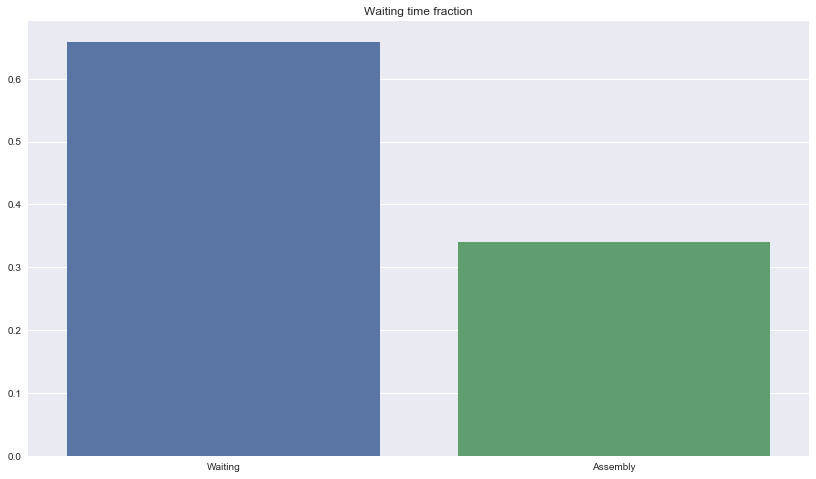

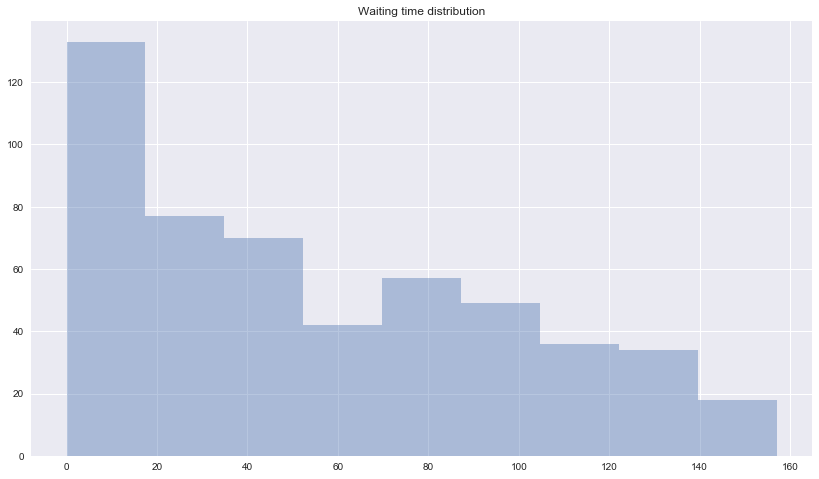

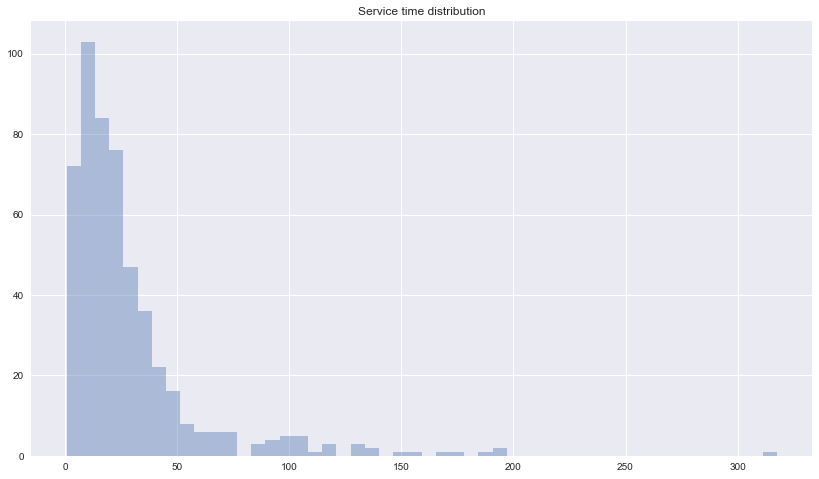

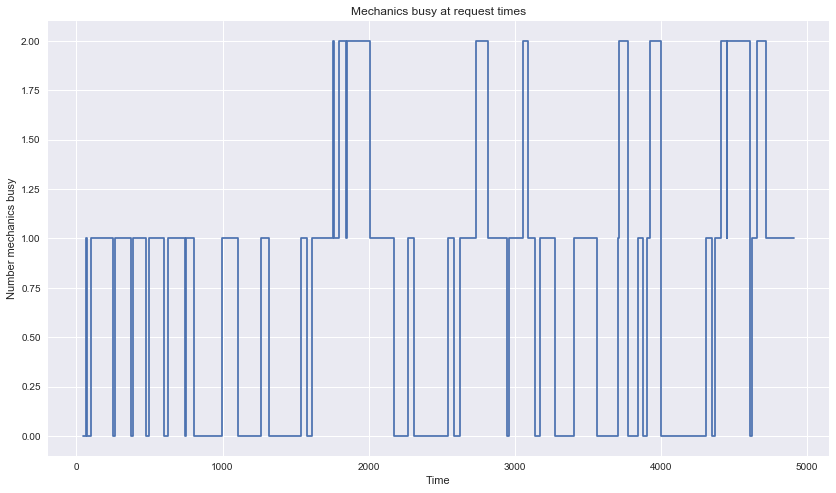

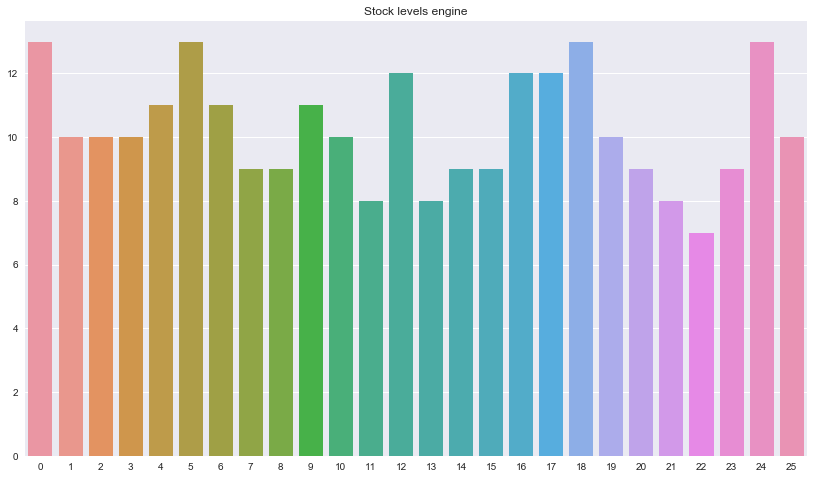

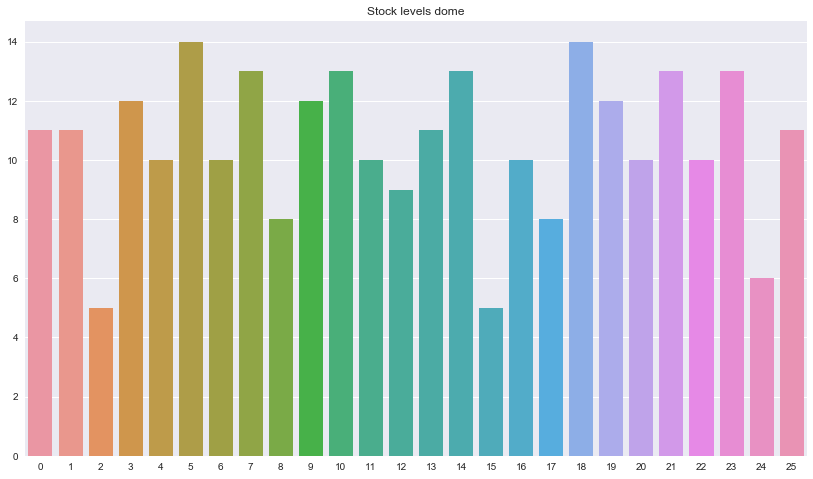

In [545]:
arrival_rate = 9

engine_initial_amount = 25
engine_restock_level = 15
engine_restock_amount = 20
engine_restock_time = 30

eng_assembly_capacity = 2
eng_assembly_service_rate = 9
eng_assembly_break_probability = 0.1

dome_initial_amount = 25
dome_restock_level = 15
dome_restock_amount = 20
dome_restock_time = 30

dome_assembly_capacity = 2
dome_assembly_service_rate = 10
dome_assembly_break_probability = 0.08

mechanic_capacity = 2
mechanic_service_rate = 40

factory = Factory(arrival_rate, engine_initial_amount, engine_restock_level, engine_restock_amount, engine_restock_time,
                  eng_assembly_capacity, eng_assembly_service_rate, eng_assembly_break_probability,
                  dome_initial_amount, dome_restock_level, dome_restock_amount, dome_restock_time,
                  dome_assembly_capacity, dome_assembly_service_rate, dome_assembly_break_probability,
                  mechanic_capacity, mechanic_service_rate, debug=False)
factory.run(5000)
factory.analysis()

## Test robustness on arrival rates

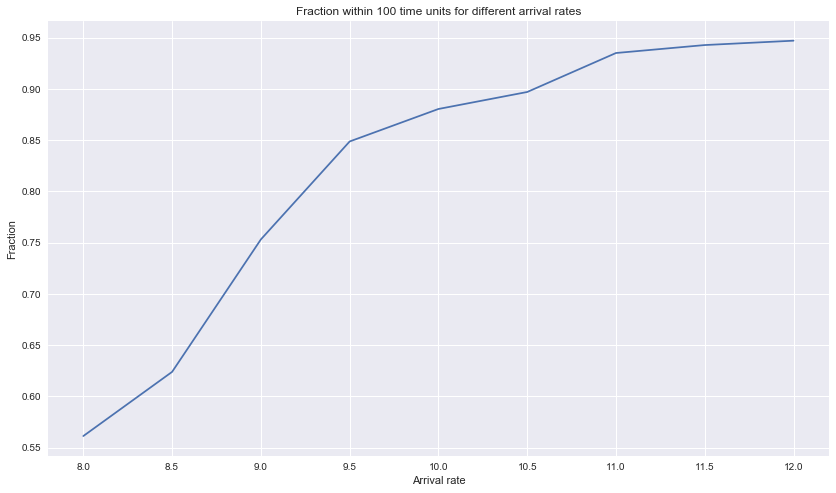

In [527]:
arrival_rate = 9

engine_initial_amount = 25
engine_restock_level = 15
engine_restock_amount = 20
engine_restock_time = 30

eng_assembly_capacity = 2
eng_assembly_service_rate = 9
eng_assembly_break_probability = 0.1

dome_initial_amount = 25
dome_restock_level = 15
dome_restock_amount = 20
dome_restock_time = 30

dome_assembly_capacity = 2
dome_assembly_service_rate = 9
dome_assembly_break_probability = 0.08

mechanic_capacity = 2
mechanic_service_rate = 40

arrival_rates = [8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12]

percentage_within_100 = []

for arrival_rate in arrival_rates:
    factory = Factory(arrival_rate, engine_initial_amount, engine_restock_level, engine_restock_amount, engine_restock_time,
                      eng_assembly_capacity, eng_assembly_service_rate, eng_assembly_break_probability,
                      dome_initial_amount, dome_restock_level, dome_restock_amount, dome_restock_time,
                      dome_assembly_capacity, dome_assembly_service_rate, dome_assembly_break_probability,
                      mechanic_capacity, mechanic_service_rate, debug=False)
    factory.run(100000)
    percentage_within_100.append(factory.percentage_within_time(100))

plt.plot(arrival_rates, percentage_within_100)
plt.title('Fraction within 100 time units for different arrival rates')
plt.xlabel('Arrival rate')
plt.ylabel('Fraction')